In [10]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


In [11]:
'''
3 layer nnet

'''

def model():
    
    dim_input = 1
    n_hidden1 = 10
    n_hidden2 = 35
    n_hidden3 = 30
    dim_output = 1
    
    x_in = tf.placeholder(tf.float32, shape = [None,1])
    
    w1 = tf.Variable(tf.truncated_normal([dim_input,n_hidden1]))
    b1 = tf.Variable(tf.zeros([n_hidden1]))
    l1 = tf.nn.sigmoid(tf.matmul(x_in,w1) + b1)
    
    w2 = tf.Variable(tf.truncated_normal([n_hidden1,n_hidden2]))
    b2 = tf.Variable(tf.zeros([n_hidden2]))
    l2 = tf.nn.sigmoid(tf.matmul(l1,w2) + b2)
    
    w3 = tf.Variable(tf.truncated_normal([n_hidden2,n_hidden3]))
    b3 = tf.Variable(tf.zeros([n_hidden3]))
    l3 = tf.nn.sigmoid(tf.matmul(l2,w3) + b3)
    
    w4 = tf.Variable(tf.truncated_normal([n_hidden3,dim_output]))
    b4 = tf.Variable(tf.zeros([dim_output]))
    y_pred = tf.matmul(l3,w4) 
    
  
    basis = l3
    params = w4
    
    return x_in, y_pred, l3
    
    
def train(x, out, x_train,y_train, n_epochs, sess):
    Y_train = tf.placeholder(tf.float32, shape=[None,1])
    
    MSEloss = tf.reduce_mean(tf.square(Y_train-out))
    train = tf.train.AdamOptimizer().minimize(MSEloss)
    init_op = tf.initialize_all_variables()
    sess.run(init_op)
    
    for i in range(n_epochs):        
        sess.run(train, feed_dict = {x:np.reshape(x_train,(-1,1)), Y_train: np.reshape(y_train,(-1,1))})

    
    
    
    

In [50]:

def objective(x):
    y = 2*np.sin(x) + np.cos(x);# + 0.01*np.random.rand();
    return y #+ 0.05*np.random.randn(*y.shape)

#train data
x_train = np.linspace(-5,5,10)
np.random.shuffle(x_train)
y_train = objective(x_train)

x_train = np.reshape(x_train, (-1,1))
y_train = np.reshape(y_train, (-1,1))

#test data
xtest = np.linspace(-8,8,20)
ytest = objective(xtest)

xtest = np.reshape(xtest,(-1,1))
ytest = np.reshape(ytest,(-1,1))



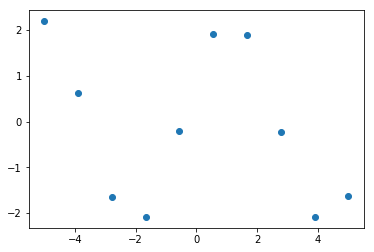

In [51]:
plt.scatter(x_train,y_train)


In [52]:
class posterior():
    #3 pages of math later...
    # a = 1/var(data) b = 1/var(params)  
    #mu 
    #dim(map_params) = (1,x_features)
    #dim(A) = (numtrain, x_features), dim(xtest) = (x_features, 1), dim(ytrain) = (numtrain,1)
    #dim(Av) = (x_features, x_features), dim(lambda_pos)=(1)
    
    
    
    
    def __init__(self, basis, xplaceholder, xtrain, ytrain,a,b, sess):
        #A = sess.run(basis, feed_dict = {})
        #make A
        
        self._a = a
        self._b = b
        self._sess = sess
        self._basis = basis
        self._xplaceholder = xplaceholder
        iden = tf.Variable(initial_value = np.identity(30))
        iden =  tf.cast(iden, tf.float32)

        sess.run(tf.initialize_all_variables())
        
        self._A = sess.run(basis, feed_dict = {xplaceholder:xtrain})  
        #self._A2 = sess.run(basis, feed_dict = {xplaceholder:xtrain})  
        #tf.print_function(print(self._A))
        
        self._Av = tf.matrix_inverse(self._a*tf.matmul(tf.transpose(self._A),self._A) + (self._b)*(self._b)*iden)
        self._A = tf.cast(self._A, tf.float64)
        self._Av = tf.cast(self._Av, tf.float64)
        self._map_params = tf.matmul(tf.matmul(self._Av, tf.transpose(self._A)),ytrain)
        
        
        #self._map_params = self._a*tf.matmul(tf.matmul(tf.matrix_inverse(self._Av),tf.transpose(self._A)), ytrain)
        #self._map_params = tf.transpose(self._map_params)
        #(numfeatures, 1)

    def predict(self, xtest):
        xtest = self._sess.run(self._basis, feed_dict = {self._xplaceholder:xtest})
        xtest = tf.cast(xtest, tf.float64)
        s1 = tf.matmul(xtest, self._Av)
        self._phiK = tf.matmul(self._Av, tf.transpose(xtest)) #(num dim, num samples)
        #lambd_pos =  (1/self._a) + tf.mul(tf.transpose(xtest), self._phiK),0)
        lambd_pos =  (1/self._a) + tf.matmul(s1, tf.transpose(xtest))
        mu_pos = self._a*tf.matmul(xtest, self._map_params)
        
        return (lambd_pos.eval(), mu_pos.eval())
        
        


     

In [53]:
with tf.Session() as sess:
    xplace,out, basis = model()
    train(xplace,out,x_train,y_train,1000,sess)
    aa = sess.run(basis, feed_dict = {xplace:xtest})
    bayeslinear = posterior(basis, xplace, x_train, y_train, 8,0.4, sess)
    y_hat = bayeslinear.predict(np.reshape(xtest, (-1,1)))

In [54]:
n = y_hat[0].shape[0]
stdv = np.zeros(n)
for i in range(n):
    stdv[i] = np.sqrt(y_hat[0][i][i])

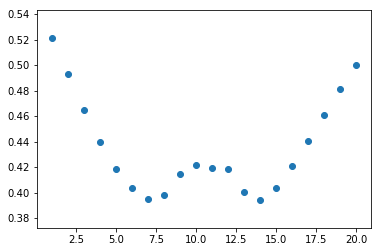

In [55]:
stdv = np.reshape(stdv,(-1,1))
mu = y_hat[1]
plt.scatter(np.linspace(1,n,n),stdv)

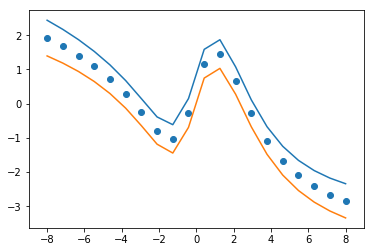

In [60]:
plt.plot(xtest,mu+stdv)
plt.plot(xtest,mu-stdv)
plt.scatter(xtest,mu)

In [58]:
from scipy.stats import norm
class acq():    
    def __init__(self, mode = "UCG"):
        self._mode = mode
        
    def EI(self, mu, sd):
        minval = np.min(mu)
        EI_score = np.zeros(len(mu))
        for i in range(len(mu)):
            EI_score[i] = mu[i]/2 + norm.cdf(minval, mu[i], sd[i])           
        return EI_score
    
acqu = acq()
ei = acqu.EI(mu,stdv)
        
        
        
        


In [59]:
ei

array([ 0.95855632,  0.83946613,  0.70264965,  0.54403852,  0.3577022 ,
        0.13614958, -0.12395162, -0.39291921, -0.51429859, -0.13587345,
        0.58393561,  0.7252221 ,  0.33802912, -0.14198096, -0.53869364,
       -0.83093189, -1.0027286 , -1.02876136, -0.97655349, -0.91966905])

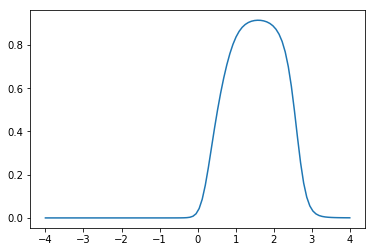

In [ ]:
np.reshape(xtest,(-1,1))[]